In [1]:
import numpy
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras import backend as K
import tensorflow
K.set_image_dim_ordering('th')

Using TensorFlow backend.


## Restricting GPU memory usage

The code here should be added to any work you do on Volta.  If you don't, then your code will monopolize all available memory on each of the 4 GPUs on the machine, preventing others from working on it.  If you do **that**, you will be frowned upon.

The code in the next cell has the effect that:
1. Memory use will start off with some small fraction of the memory on each GPU.
1. It will grow if necessary (since `allow_growth` is set to `True`).
1. It will max out at 5% of overall memory.  Given the GPUs we have, this gives you (4 x 808 MB), which should be sufficient here.

In [2]:
config = tensorflow.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.05
K.tensorflow_backend.set_session(tensorflow.Session(config=config))

## load cifar10 image_data
1. First of all, load traindata and traindata from cifar10. `x_train,x_test` are uint8 array of RGB image data ,and `y_train,Y_table` are  uint8 array of category labels (integers in range 0-9).
1. Initialize the random number seed with a constant to ensure the results are reproducible.

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
seed = 7
numpy.random.seed(seed)

## Normalization of data
Every time we should normalization data( let data from(0,1)).
The pixel values are in the range of 0 to 255 for each of the red, green and blue channels.
It is good practice to work with normalized data. Because the input values are well understood, we can easily normalize to the range 0 to 1 by dividing each value by the maximum observation which is 255.
Note, the data is loaded as integers, so we must cast it to floating point values in order to perform the division.

In [4]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

## Transform labal_data to binary matrix
1. Using`np_utils.to_categorical()` method to let labal be onehot format like(1,0,0,0,0,0,0,0,0,0).This binary format let algrorithm's prediction be easy. 
2. Give the number of labal to num_classes

In [5]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

## Built the model's layers
1. Sequential model is a linear stack of layers. You can add layers to build model you want.

2.  This is a shape tuple.Conv2D layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs.the input parameter`32`means output space have 32  dimensionality, `(3,3)` means height and width of the 2D convolution window, Fist layer you must Pass `input_shape` argument`(3,32,32)`means 32x32 RGB pictures in  data_format="channels_last",activation function is `relu`   ![image](  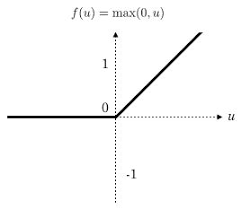)    `padding=same`means you can have 0 to handle with padding.

1. Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly. In this model we set drop probability to 0.2. It is good technology to make model genenralize well.

1. MaxPooling2D(pool_size=(2,2)) is also the layer to prevent overfitting and also can decrease calculation step. `pool_size=(2,2)` means downscale (vertical, horizontal). (2, 2) will halve the input in both spatial dimension.

1. `Flatten()` means let the input multidimension data change to one dimension.

1. Dense(1024, activation='relu', kernel_constraint=maxnorm(3)) implements the operation: `output = activation(dot(input, kernel) + bias)`. The parameter`1024` means output space have 1024 dimentionaliity.'activation='relu' means use relu function to be activation function. `kernel_constraint=maxnorm(3)` means constraint function applied to the kernel weights matrix .

1. model.add(Dense(num_classes, activation='softmax')) means the last layer will give 10 dimentionality output and use `softmax `to be activation function   ![image]( https://upload-images.jianshu.io/upload_images/1531909-a0d0107595ea6f36.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/632/format/webp)       
### Test
I try to add 4 layers to this model but it is useless ,and it will decrease the accurcy. I think the reason is too much convolution layers let the model loss a lot feature, and still use `dropout`and `MaxPooling2D` to prevent overfitting ,it makes performance decrease.So i just add one convolution layer, but the accuray can be 89.5% ,it is not increase a lot.


In [6]:
model = Sequential()#1
model.add(Conv2D(32, (3, 3), input_shape=(3, 32, 32), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(48, (3, 3), activation='relu', padding='same'))
# model.add(Dropout(0.2))
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

## compile model
1. We set epochs to 200 means data will loop 200 times to training network.
3. We use Stochastic Gradient Descent (SGD) to be optimizer to get what value can let loss function be small.`SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)` .we set learning rate to 0.02,and `decay` means learning rate will decy in every loop for epochs.`neterov=False` means do not use Nesterov momentum.
4.  `compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])`. we use `categorical_crossentropy`to be loss function,and  `metrics`: List of metrics to be evaluated by the model during training and testing. Typically you will use  metrics=['accuracy'].
### Test
I try to use `adddelta` to be the optimizer, but result is not good. Accuracy is only 78.9%.

In [7]:
# Compile model
epochs = 100
lrate = 0.02
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 16, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 16, 16)        13872     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 16, 16)        27712     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 16, 16)        0         
__________

## data augumentation
1. I use keras.preprocessing.image.ImageDataGenerator() to relize image data augumentation,
  `featurewise_center=False` set input mean to 0 over the dataset,
  `samplewise_center=False`  set each sample mean to 0,
  ` featurewise_std_normalization=False`  divide inputs by std of the dataset,
  `samplewise_std_normalization=False` divide each input by its std,
  ` zca_whitening=False`   apply ZCA whitening,
  `rotation_range=10`  randomly rotate images in the range (degrees, 0 to 180),
  `width_shift_range=0.2` randomly shift images horizontally (fraction of total width),
  `height_shift_range=0.2`  randomly shift images vertically (fraction of total height),
  `horizontal_flip=True`   randomly flip images.
1. `augumentation.fit(X_train)` is method to use `ImageDataGenerator` to deal with training data.
2. `augumentation.flow(X_train, y_train)` return an iterator yielding tuples of (x, y).
3. `model.evaluate(x_test,y_test,verbose=0)`is the method to evaluate model.`verbose=0`means silent.
### Test
After i use augumentation, the accuracy increase to 89%.It is really useful! And i find that if your `batch_size` set large ,the accuracy will be lower.I think if the `batch_size`is too large.Because of `SGD` feature, we will be easy to lock in local minimum point.But if `batch_size` set small,the network will be more randomly so that it is more possible to break local mimimun point.

In [ ]:
augumentation=ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False, 
        rotation_range=10,  
        width_shift_range=0.2,  
        height_shift_range=0.2,  
        horizontal_flip=True,  
        vertical_flip=False) 
augumentation.fit(X_train)
gen = augumentation.flow(X_train, y_train,batch_size=64)
model.fit_generator(generator=gen,steps_per_epoch=5000, 
                                 epochs=epochs, 
                                 validation_data=(X_test, y_test))
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/5000
5000/5000 [==============================] - 144s 29ms/step - loss: 1.5730 - acc: 0.4222 - val_loss: 1.1472 - val_acc: 0.5884
Epoch 2/5000
5000/5000 [==============================] - 138s 28ms/step - loss: 1.1298 - acc: 0.5987 - val_loss: 0.8993 - val_acc: 0.6867
Epoch 3/5000
5000/5000 [==============================] - 138s 28ms/step - loss: 0.9930 - acc: 0.6519 - val_loss: 0.7918 - val_acc: 0.7255
Epoch 4/5000
5000/5000 [==============================] - 141s 28ms/step - loss: 0.9309 - acc: 0.6768 - val_loss: 0.7522 - val_acc: 0.7436
Epoch 5/5000
4350/5000 [=========================>....] - ETA: 18s - loss: 0.9010 - acc: 0.6895